# Analyis for the Dark Machines Collider Unsupervised Challenge
This notebook examines the results for the [hackathon dataset](https://zenodo.org/record/3961917#.X2tooJNKhQM). The methods were trained on background only samples and then applied to a mix of background and signal.

The goal of this notebook is to move beyond the figures of merit. Some physics signals appear in multiple signal regions. We combine the Signifiance Improvement coming from the anomaly detection techniques across the signal regions to determine which models have the best chance at discovering new physics.

Notebook author: Bryan Ostdiek (bostdiek at g.harvard.edu)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.markers as mmark

from scipy.interpolate import interp1d

from os import walk, path

from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(f'Using numpy version {np.version.version}: known to work with 1.19.1')
print(f'Using pandas version {pd.__version__}: known to work with 1.1.1')

Using numpy version 1.19.1: known to work with 1.19.1
Using pandas version 1.1.1: known to work with 1.1.1


Some functions may not work with different versions of numpy or pandas

In [3]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

# Load Data
## Auto Encoder 
Submission by Baptiste Ravina. Details on the method can be found in section 4.1 of the paper.

In [4]:
AE = pd.read_csv('../data/AE.csv')

AEModels = list(AE['Model'].unique())
print(len(AEModels))

1


## Variational Auto Encoders
Submission by Luc Hendriks. Details on the method can be found in section 4.2 of the paper.

In [5]:
VAEs = pd.read_csv('../data/VAE.csv')

VAEModels = list(VAEs['Model'].unique())
print(len(VAEModels))

140


## Deep Set VAE
Submission by Bryan Ostdiek. Details on the method can be found in section 4.3 of the paper.

In [6]:
DeepSetVAE = pd.read_csv('../data/DeepSetVAE.csv')

DeepSetVAEModels = list(DeepSetVAE['Model'].unique())
print(len(DeepSetVAEModels))

4


## ConvVAE with and without flows.
Submission by Pratik Jawahar. Details on the methods can be found in sections 4.4 (without flows) and 4.5 (with flows).

In [7]:
ConvVAE = pd.read_csv('../data/ConvVAE_and_Flows.csv')

ConvVAEModels = list(ConvVAE['Model'].unique())
print(len(ConvVAEModels))

7


## CNN-(B)VAE
Submissions by Joe Davies. Information can be found in section 4.6 of the paper.

In [8]:
CNNVAE = pd.read_csv('../data/CNN_VAE.csv')
CNNBVAE = pd.read_csv('../data/CNN_BVAE.csv')

CNNVAEModels = list(CNNVAE['Model'].unique())
print(len(CNNVAEModels))
CNNBVAEModels = list(CNNBVAE['Model'].unique())
print(len(CNNBVAEModels))

1
1


## Density Estimation
Submission by Alessandro Morandini. Information can be found in section 4.7 of the paper.

In [9]:
KDE = pd.read_csv('../data/KDE.csv')

KDEModels = list(KDE['Model'].unique())
print(len(KDEModels))

36


## Flows
Submission by Luc Hendriks. Information can be found in section 4.8 of the paper.

In [10]:
Flows = pd.read_csv('../data/Flow.csv')

FlowsModels = list(Flows['Model'].unique())
print(len(FlowsModels))

2


## Deep SVDD
Submission by Luc Hendriks. Infromation can be found in section 4.9 of the paper.

In [11]:
DeepSVDD = pd.read_csv('../data/DeepSVDD.csv')

DeepSVDDModels = list(DeepSVDD['Model'].unique())
print(len(DeepSVDDModels))

80


## Combinations of Flows and Deep SVDD or VAE
Submission by Luc Hendriks. Information can be found in section 4.10 of the paper.

In [12]:
Combined = pd.read_csv('../data/Combined.csv')

CombinedModels = list(Combined['Model'].unique())
print(len(CombinedModels))

8


## DAGMM
Submission by Roberto Ruiz. Information can be found in section 4.11 of the paper.

In [13]:
DAGMM = pd.read_csv('../data/DAGMM.csv')

DAGMMModels = list(DAGMM['Model'].unique())
print(len(DAGMMModels))

384


## ALAD
Submission by Roberto Ruiz. Information can be found in section 4.12 of the paper.

In [14]:
ALAD = pd.read_csv('../data/ALAD.csv')

ALADModels = list(ALAD['Model'].unique())
print(len(ALADModels))

96


## Latent Space Methods
Submission by Adam Leinweber. Information can be found in section 4.13 of the paper.

In [15]:
Latent = pd.read_csv('../data/MethodsInLatentSpaceOfVAE.csv')

LatentModels = list(Latent['Model'].unique())
print(len(LatentModels))

288


## Concatenate into a single data frame

In [16]:
names = ['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
AllCombined = np.array(AE[names])
AllCombined = np.vstack([AllCombined, VAEs[names]])
AllCombined = np.vstack([AllCombined, DeepSetVAE[names]])
AllCombined = np.vstack([AllCombined, ConvVAE[names]])
AllCombined = np.vstack([AllCombined, CNNVAE[names]])
AllCombined = np.vstack([AllCombined, CNNBVAE[names]])
AllCombined = np.vstack([AllCombined, KDE[names]])
AllCombined = np.vstack([AllCombined, Flows[names]])
AllCombined = np.vstack([AllCombined, DeepSVDD[names]])  
AllCombined = np.vstack([AllCombined, Combined[names]]) 
AllCombined = np.vstack([AllCombined, DAGMM[names]])
AllCombined = np.vstack([AllCombined, ALAD[names]])
AllCombined = np.vstack([AllCombined, Latent[names]])
AllCombined = pd.DataFrame(AllCombined, columns=names)

In [17]:
AllCombined

,Signal,Model,Chan,AUC,1e-2,1e-3,1e-4
0,stop2b1000_neutralino300,AE,1,0.872,0.211,0.097,0.047
1,monojet_Zp2000.0_DM_50.0,AE,1,0.724,0.106,0.045,0.015
2,monotop_200_A,AE,1,0.714,0.13,0.077,0.037
3,glgl1400_neutralino1100,AE,1,0.79,0.15,0.083,0.043
4,stlp_st1000,AE,1,0.968,0.703,0.525,0.314
...,...,...,...,...,...,...,...
35547,sqsq1_sq1400_neut800,LS_Average_4_0.1_10000,3,0.795075,0.0478249,0.00681342,0.00222746
35548,sqsq1_sq1400_neut800,LS_Average_4_1.0_1000,3,0.805776,0.16326,0.019261,0.00393082
35549,sqsq1_sq1400_neut800,LS_Average_4_1.0_10000,3,0.765942,0.137317,0.0259434,0.00366876
35550,sqsq1_sq1400_neut800,LS_Average_4_1e-05_1000,3,0.875899,0.200996,0.0476939,0.0086478


Check to make sure all models have results for all of the signals.

In [18]:
incomplete_models = []
for Chan in ['1', '2a', '2b', '3']:
    for mod in list(AllCombined['Model'].unique()):
        if mod not in list(AllCombined[AllCombined['Chan'] == Chan]['Model']):
            print(f'Missing Chan {Chan} for {mod}')
            incomplete_models.append(mod)

print(f'....Dropping {len(incomplete_models)} incomplete models')
AllCombined = AllCombined[~AllCombined['Model'].isin(incomplete_models)].copy()

print(f'\nResults are computed for {AllCombined.Model.unique().shape[0]} models')

Missing Chan 3 for DeepSVDD_Reduced_d377
Missing Chan 3 for DeepSVDD_C0_d377
Missing Chan 3 for DeepSVDD_C1_d377
Missing Chan 3 for DeepSVDD_C2_d377
Missing Chan 3 for DeepSVDD_C3_d377
Missing Chan 3 for DeepSVDD_C4_d377
Missing Chan 3 for DeepSVDD_C10_d377
Missing Chan 3 for DeepSVDD_C25_d377
....Dropping 8 incomplete models

Results are computed for 1040 models


# Significance Improvement

We use the following to define the significance improvement, assuming that there are enough counts for Gaussian statistics.

$\rm{Base~Significance} = \frac{N_S }{N_B} = \frac{\sigma_S}{\sqrt{\sigma_B}}$

$\rm{Significance} = \rm{Significance~Improvement}\times\rm{Base~Significance} = \frac{N_S^{\rm{cut}}}{N_B^{\rm{cut}}} = \frac{\epsilon_S * \sigma_S}{\sqrt{\epsilon_B * \sigma_B}} = \frac{\epsilon_S }{\sqrt{\epsilon_B }} \times \rm{Base~Significance}$

In [19]:
AllCombined['SI_1e-2'] = AllCombined['1e-2'] / np.sqrt(1e-2)
AllCombined['SI_1e-3'] = AllCombined['1e-3'] / np.sqrt(1e-3)
AllCombined['SI_1e-4'] = AllCombined['1e-4'] / np.sqrt(1e-4)

We don't care if we use a loose, medium, or tight background cut. We chose whichever one maximizes the significance improvement.

In [20]:
AllCombined['SI_All'] = AllCombined[['SI_1e-2', 'SI_1e-3', 'SI_1e-4']].max(axis=1)

Now find the signals which appear in multiple channels. For each of these, we will only use the maximum significance improvement. Thus if a signal has an SI of 1.0 in chan2a, and an SI of 3.2 in chan3, we will only take the 3.2. This will be called the _Total Improvement_.

In [21]:
AllSigs = list(AllCombined['Signal'].unique())

In [22]:
AllMods = list(AllCombined['Model'].unique())
SI_DF = pd.DataFrame()
SI_DF['Model'] = AllMods

for sig in AllSigs:
    si_list = []
    for mod in AllMods:
        tmp_df = AllCombined[(AllCombined['Model'] == mod)]
        si_list.append(tmp_df[tmp_df['Signal'] == sig]['SI_All'].max())
    SI_DF[sig] = si_list

Now find the maximum, median, and minimum significance improvements for each model across all of the signals.

In [23]:
SI_DF['MinTotalImprovement'] = SI_DF[[col for col in SI_DF if 'Model' not in col]].min(axis=1)
SI_DF['MaxTotalImprovement'] = SI_DF[[col for col in SI_DF if (('Model' not in col) and ('MinTotalImprovement' not in col))]].max(axis=1)
SI_DF['MedianTotalImprovement'] = SI_DF[[col for col in SI_DF if (('Model' not in col) and ('MinSMinTotalImprovementigI' not in col) and ('MaxTotalImprovement' not in col))]].median(axis=1)


Define colors and markers for the different models.

In [24]:
mycolors = ['#a6cee3',  # Latent Space Model,
            '#FFD500',  # ALAD
            '#b15928',  # DAGMM
            '#1f78b4',  # Normalizing Flow Models
            '#1f78b4',  # Normalizing Flow Models
            '#1f78b4',  # Normalizing Flow Models
            '#1f78b4',  # Normalizing Flow Models
            '#1f78b4',  # Normalizing Flow Models
            '#b2df8a',  # DensityBasedModels
            '#33a02c',  # VAE_MODELS
            '#fb9a99',  # Flow-Efficient Models
            '#e31a1c',  # CombinedModels
            '#fdbf6f',  # FixedTargetModels
            '#ff7f00',  # DeepSetModels
            '#6a3d9a',  # CNN
            '#cab2d6',  # Crude AE
           ]

mymarkers = ['o',  # Latent Space Models
             'P',  # ALAD
             'X',  # DAGMM
             'v',  # CONV
             'd',  # Planar
             's',  # SNF
             'p',  # IAF
             '.',  # ConvF
             '^',  # DensityBasedModels
             '<',  # VAE_MODELS
             '*',  # Flow-Efficient Models
             's',  # CombinedModels
             'p',  # FixedTargetModels
             '>',  # DeepSetModels
             'D',  # CNN
             'h',  # Crude AE
            ]

mymodel_list = [SI_DF[SI_DF['Model'].str.startswith('LS')],  # Latent Space Models,
                SI_DF[SI_DF['Model'].str.startswith('ALAD')],  # ALAD
                SI_DF[SI_DF['Model'].str.startswith('DAGMM')],  # DAGMM
                SI_DF[SI_DF['Model'].str.startswith('VAE_NoF')],  # CONV 
                SI_DF[SI_DF['Model'].str.startswith('VAE_PlanarFlow')],  # Planar
                SI_DF[SI_DF['Model'].str.endswith('SNF')],  # SNF
                SI_DF[SI_DF['Model'].str.startswith('VAE_IAF')],  # IAF
                SI_DF[SI_DF['Model'].str.startswith('VAE_ConvolutionalFlow')],  # ConvF
                SI_DF[SI_DF['Model'].isin(KDEModels)],  # DensityBasedModels
                SI_DF[SI_DF['Model'].isin(VAEModels)],  # VAE_MODELS
                SI_DF[SI_DF['Model'].str.startswith('Flow-Efficient')],  # Flow-Efficient Models
                SI_DF[SI_DF['Model'].isin(CombinedModels)],  # CombinedModels
                SI_DF[SI_DF['Model'].isin(DeepSVDDModels)],  # FixedTargetModels
                SI_DF[SI_DF['Model'].isin(DeepSetVAEModels)],  # DeepSetModels
                SI_DF[SI_DF['Model'].str.startswith('CNN')],  # CNN
                SI_DF[SI_DF['Model'].str.startswith('AE')],  # Cude AE
               ]

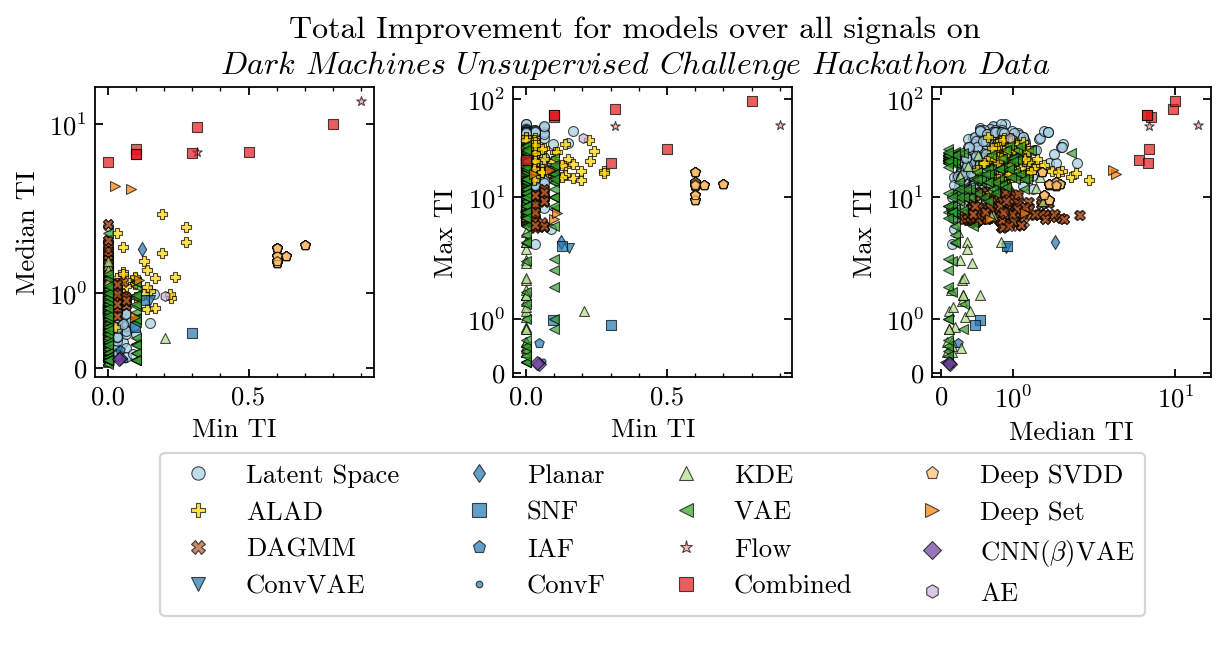

In [25]:
plt.figure(figsize=(9, 4.5))
s=20

gs0 = gs.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.25)
gs00 = gs.GridSpecFromSubplotSpec(1, 3, gs0[0], wspace=0.5)
plt.subplot(gs00[0])
for i, model in enumerate(mymodel_list):
    tmpdf=model
    plt.scatter(tmpdf['MinTotalImprovement'], tmpdf['MedianTotalImprovement'], color=mycolors[i], marker=mymarkers[i], s=s, alpha=0.7, rasterized=True,
               linewidths=0.5, edgecolor='k' )
    plt.yscale('symlog')
plt.xlabel('Min TI')
plt.ylabel('Median TI')
plt.minorticks_on()


plt.subplot(gs00[1])
for i, model in enumerate(mymodel_list):
    tmpdf=model
    plt.scatter(tmpdf['MinTotalImprovement'], tmpdf['MaxTotalImprovement'], color=mycolors[i], marker=mymarkers[i], s=s, alpha=0.7, rasterized=True,
               linewidths=0.5, edgecolor='k' )
    plt.yscale('symlog')
plt.xlabel('Min TI')
plt.ylabel('Max TI')
plt.minorticks_on()



plt.subplot(gs00[2])
for i, model in enumerate(mymodel_list):
    tmpdf=model
    plt.scatter(tmpdf['MedianTotalImprovement'], tmpdf['MaxTotalImprovement'], color=mycolors[i], marker=mymarkers[i], s=s, alpha=0.7, rasterized=True,
               linewidths=0.5, edgecolor='k' )
    plt.xscale('symlog')
    plt.yscale('symlog')
plt.xlabel('Median TI')
plt.ylabel('Max TI')
plt.minorticks_on()

plt.suptitle('Total Improvement for models over all signals on\n' +  '$Dark$ $Machines$ $Unsupervised$ $Challenge$ $Hackathon$ $Data$')  # ' + ' $(\epsilon_S / \sqrt{\epsilon_B})$' + '


plt.subplot(gs0[1])
plt.legend([Line2D([0], [0], color=mycolors[i], marker=mymarkers[i], alpha=0.7, linestyle='None', mec ='black', mew = 0.5) for i in range(16)],
           ['Latent Space', 'ALAD', 'DAGMM',
            'ConvVAE', 'Planar', 'SNF', 'IAF', 'ConvF', 'KDE', 'VAE',
            'Flow', 'Combined', 'Deep SVDD',
            'Deep Set', r'CNN$(\beta)$VAE', 'AE'
           ],
           ncol=4,
           loc='center'
          )
plt.axis('off')
plt.savefig('../figures/SummaryOfSummaries_modelclustering_symlog.pdf', bbox_inches='tight')
plt.show()

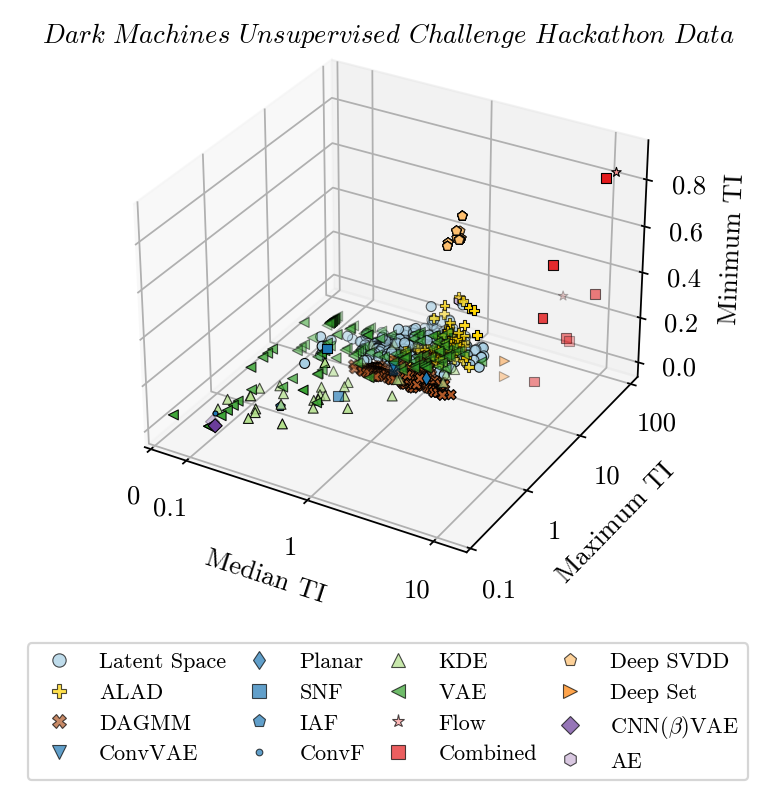

In [26]:
fig = plt.figure(figsize=(6, 6))
gs0 = gs.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.3)

ax = plt.subplot(gs0[0], projection='3d')
plt.title('$Dark$ $Machines$ $Unsupervised$ $Challenge$ $Hackathon$ $Data$', y=1.01, fontsize=12)
for i, model in enumerate(mymodel_list):
    tmpdf=model
    ax.scatter(zs=tmpdf['MinTotalImprovement'], 
               xs=np.log10(tmpdf['MedianTotalImprovement'],
                           where=tmpdf['MedianTotalImprovement']>0,
                           out=np.ones_like(tmpdf['MedianTotalImprovement']) * -1.3
                          ),
               ys=np.log10(tmpdf['MaxTotalImprovement'],
                           where=tmpdf['MaxTotalImprovement']>0,
                           out=np.ones_like(tmpdf['MaxTotalImprovement']) * -1.3
                          ),
               color=mycolors[i], 
               marker=mymarkers[i],
               s=s,
               linewidths=0.5,
               edgecolor='k' 
              )

ax.set_zlabel('Minimum TI')


ax.set_xlabel('Median TI')
plt.xlim(-1.3, np.log10(16))
plt.xticks([-1.3, -1, 0, 1], [0, 0.1, 1, 10])
ax.set_ylabel('Maximum TI')
plt.ylim(-1, np.log10(120))
plt.yticks([-1, 0, 1,2], [0.1, 1, 10, 100])

plt.subplot(gs0[1])
plt.legend([Line2D([0], [0], color=mycolors[i], marker=mymarkers[i], alpha=0.7, linestyle='None', mec ='black', mew = 0.5) for i in range(16)],
           ['Latent Space', 'ALAD', 'DAGMM',
            'ConvVAE', 'Planar', 'SNF', 'IAF', 'ConvF', 'KDE', 'VAE',
            'Flow', 'Combined', 'Deep SVDD',
            'Deep Set', r'CNN$(\beta)$VAE', 'AE'
           ],
           ncol=4,
           loc='center',
           fontsize=10,
           columnspacing=0.5
          )
plt.axis('off')


plt.savefig('../figures/Summary_3d_modelclustering.pdf', bbox_inches='tight')

Save the data for the total improvement for future visualizations.

In [27]:
TIdf = SI_DF[['Model', 'MinTotalImprovement', 'MedianTotalImprovement', 'MaxTotalImprovement']].sort_values(by='MedianTotalImprovement', ascending=False)
TIdf.to_csv('../data/DarkMachinesUnsupervisedChallenge_TotalImprovements.csv', index=False)


## Top Models
Now show results only for the models with the higest median TI.

In [28]:
top_medians = SI_DF.sort_values(by='MedianTotalImprovement', ascending=False).iloc[:9]

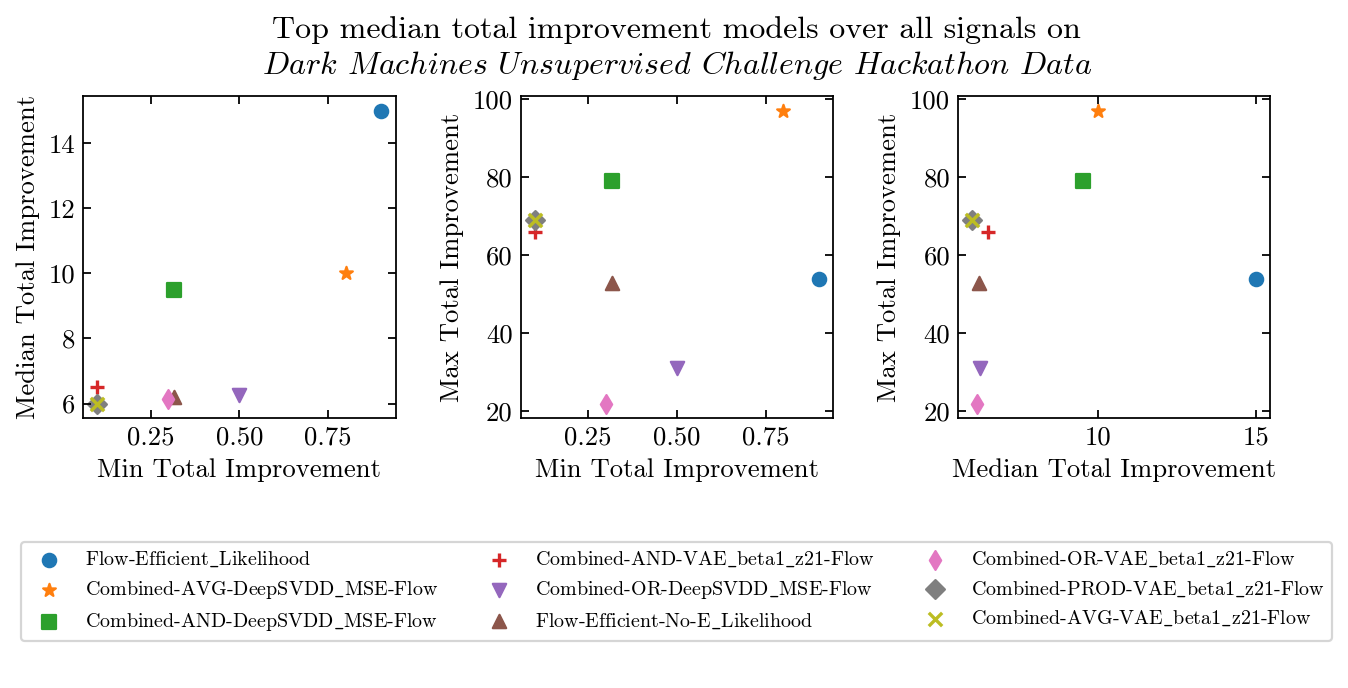

In [29]:
plt.figure(figsize=(9, 4))
gs0 = gs.GridSpec(2, 1, height_ratios=[3, 1.5])
gs00 = gs.GridSpecFromSubplotSpec(1, 3, gs0[0], wspace=0.4, hspace=5)
i=3
plt.subplot(gs00[0])
markerdict = {0: 'o',
              1: '*',
              2: 's',
              3: '+',
              4: 'v',
              5: '^',
              6: 'd',
              7: 'D',
              8: 'x',
              9: '1',
              10: '2',
              11: '3',
              12: '4',
              13: 'h',
              14: '<',
              15: '>',
             }

for kk, mod in enumerate(list(top_medians['Model'])):
    tmpdf2=top_medians[top_medians['Model'] == mod]
    plt.scatter(tmpdf2['MinTotalImprovement'], tmpdf2['MedianTotalImprovement'], color=f'C{kk}',
                marker=markerdict[kk]
               )
plt.xlabel('Min Total Improvement')
plt.ylabel('Median Total Improvement')

plt.subplot(gs00[1])

for kk, mod in enumerate(list(top_medians['Model'])):
    tmpdf2=top_medians[top_medians['Model'] == mod]
    plt.scatter(tmpdf2['MinTotalImprovement'], tmpdf2['MaxTotalImprovement'], color=f'C{kk}', label=mod.replace('VAE_beta_1.0', '-Fixed KL').replace('_', r'$\_$').replace('+', '\n'),
               marker=markerdict[kk])
plt.xlabel('Min Total Improvement')
plt.ylabel('Max Total Improvement')


plt.subplot(gs00[2])

for kk, mod in enumerate(list(top_medians['Model'])):
    tmpdf2=top_medians[top_medians['Model'] == mod]
    plt.scatter(tmpdf2['MedianTotalImprovement'], tmpdf2['MaxTotalImprovement'], 
                color=f'C{kk}',
                marker=markerdict[kk]
               )
plt.xlabel('Median Total Improvement')
plt.ylabel('Max Total Improvement')

plt.subplot(gs0[1])
for kk, mod in enumerate(list(top_medians['Model'])):
    tmpdf2=tmpdf[tmpdf['Model'] == mod]
    plt.scatter([], [], color=f'C{kk}',
                marker=markerdict[kk],
                label=mod.replace('VAE_beta_1.0', '-Fixed KL').replace('_', r'$\_$').replace('+', '\n  '),
               )
plt.legend(fontsize=9,
           loc='center',
           ncol=3
          )
plt.axis('off')

plt.tight_layout(w_pad=10)
plt.suptitle('Top median total improvement models over all signals on\n' +  '$Dark$ $Machines$ $Unsupervised$ $Challenge$ $Hackathon$ $Data$', y=1.07)

plt.savefig('../figures/SummaryOfSummaries_best.pdf', bbox_inches='tight')
plt.show()

## Significance improvement across the physics signals

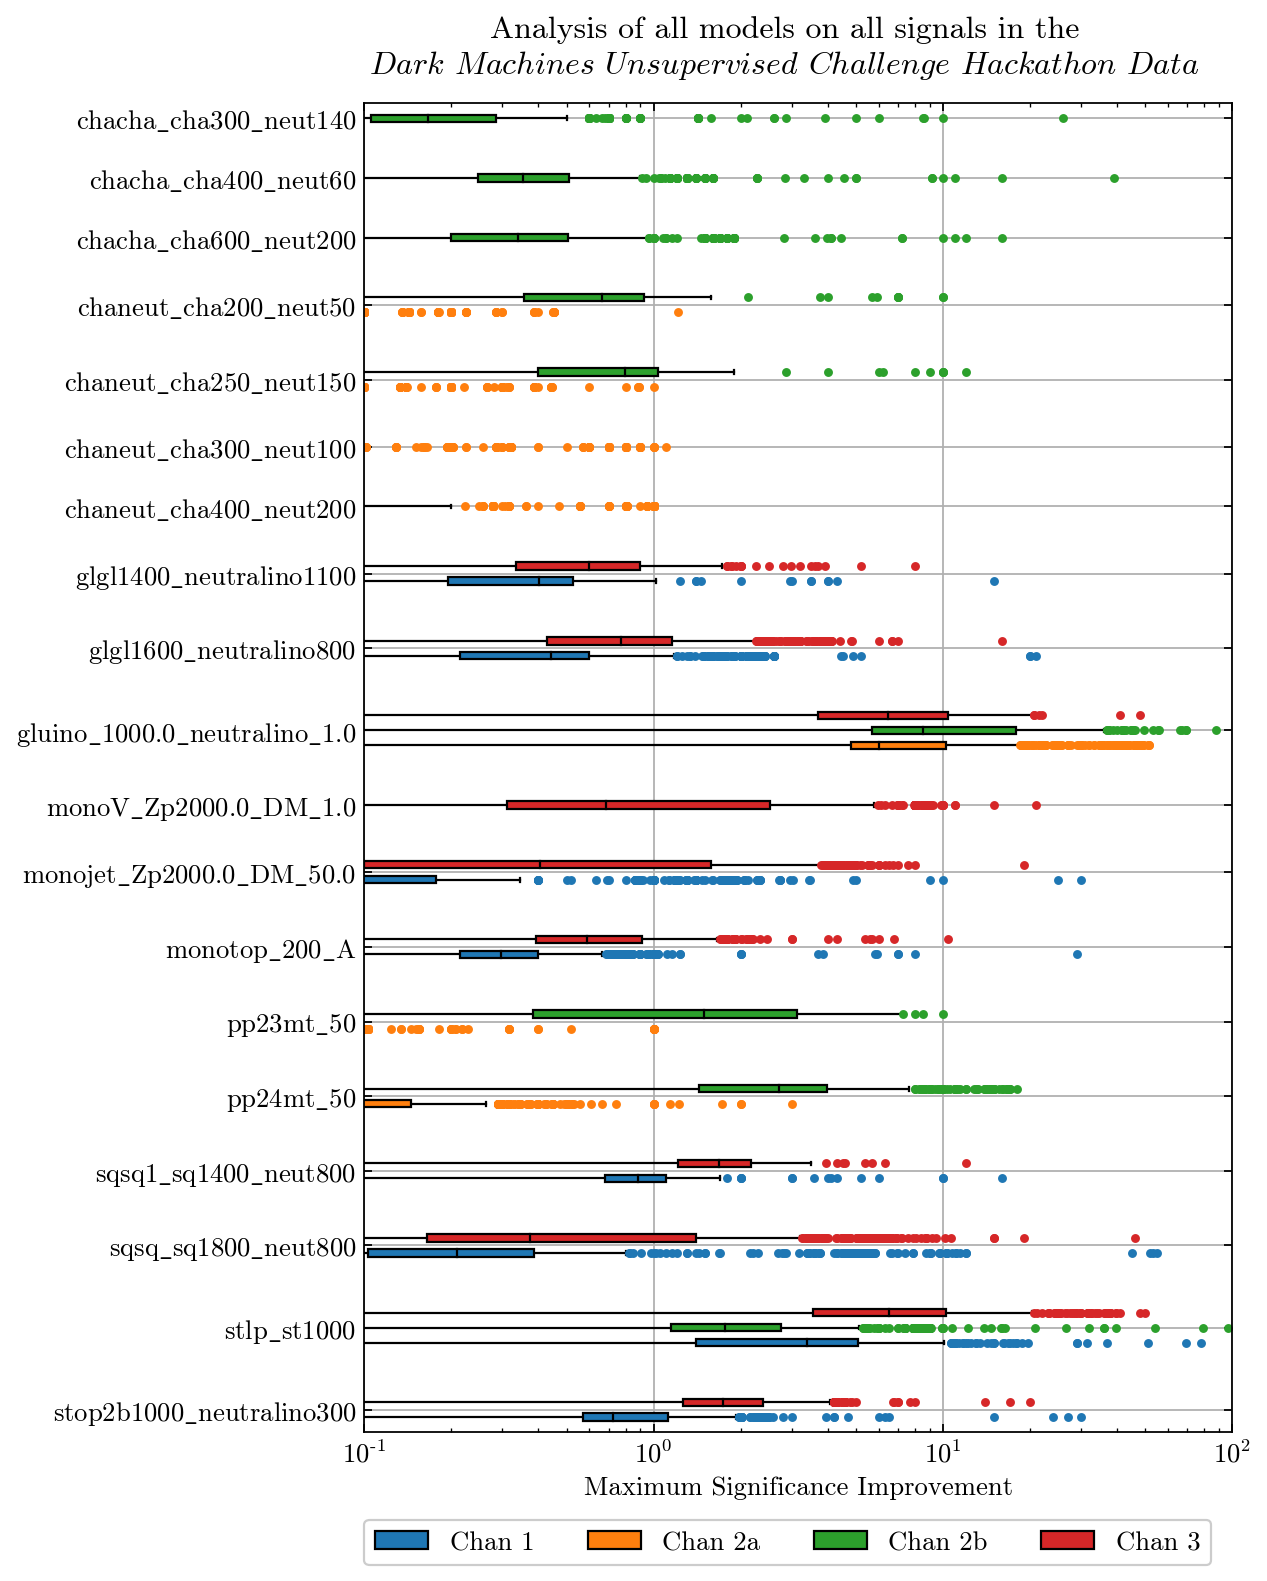

In [30]:
counter = 0
yvs = []
ListSigImp = []
my_yticks = []
my_ynames = []
mycolors = []
colordict = {'1': 'C0', '2a': 'C1', '2b': 'C2', '3': 'C3'}
plt.figure(figsize=(7, 11))
for sig in np.sort(AllSigs)[::-1]:
    tmp_df = AllCombined[AllCombined['Signal'] == sig]
    channels = list(tmp_df.Chan.unique())
    lc = len(channels)
    
    tmp_yn = []
    
    for i, chan in enumerate(channels):
        tmp_df = AllCombined[(AllCombined['Signal'] == sig) & (AllCombined['Chan'] == chan)]
        ListSigImp.append(tmp_df['SI_All'])
        yvs.append(counter)
        tmp_yn.append(counter)
        counter += 1
        mycolors.append(colordict[chan])
    counter += 3
    my_yticks.append(np.mean(tmp_yn))
    my_ynames.append(sig.replace('_', '$\_$'))
# plt.subplot(1, 4, 1)    
bbox1 = plt.boxplot(np.array(ListSigImp).T,
            vert=False,
            manage_ticks=False,
            patch_artist=True,
            medianprops={'color':'k'},
            positions=yvs
           )
plt.yticks(my_yticks, my_ynames)
plt.xlabel('Maximum Significance Improvement')
for patch, flier, color in zip(bbox1['boxes'], bbox1['fliers'], mycolors):
    patch.set_facecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markersize(3)
    flier.set_markeredgecolor(color)
plt.ylim(min(yvs)-1, max(yvs)+1)
plt.xscale('log')
plt.xlim(0.1, 100)
plt.grid()
    
    
legend_elements = [Patch(facecolor='C0', edgecolor='k',
                         label='Chan 1'),
                   Patch(facecolor='C1', edgecolor='k',
                         label='Chan 2a'),
                   Patch(facecolor='C2', edgecolor='k',
                         label='Chan 2b'),
                   Patch(facecolor='C3', edgecolor='k',
                         label='Chan 3')
                  ]
plt.legend(handles=legend_elements, 
           loc=(-0.0, -0.1), 
           labelspacing=1,
           ncol=4,
           facecolor='white',
           framealpha=1,
           frameon=True)
    
plt.suptitle('Analysis of all models on all signals in the\n' +  '$Dark$ $Machines$ $Unsupervised$ $Challenge$ $Hackathon$ $Data$', y=0.93)
plt.savefig('../figures/AllModelsAllSignals_SignificanceImprovement.pdf', bbox_inches='tight')
plt.show()
